In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Config
sns.set(color_codes=True)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
from useful_functions import *

## Score constituencies

In [3]:
election_results = read_in_election_results() 

In [4]:
#Pick year of interest
year = 19 # 2019 election
compare_year = 17

In [5]:
base = pd.DataFrame(election_results[year]['lab_pc'],
                    index=election_results[year].index)
diff = score_campaigns_difference(election_results[year], 
                                     election_results[compare_year])
uns  = score_campaigns_uns(election_results[year], 
                              election_results[compare_year])
mrp  = score_campaigns_mrp(election_results[year])

In [6]:
scores = pd.concat( [election_results[year]['Constituency'],
                     base['lab_pc'], diff['difference'],uns['difference'],mrp['difference'] ],
                    axis=1, verify_integrity=True, sort=True)
scores.columns = ['Constituency','base','diff','uns','mrp']
scores.sort_values('uns',ascending=False).head()

,Constituency,base,diff,uns,mrp
E14000589,Bradford West,0.762206,4292.0,0.194483,0.222206
E14000884,Portsmouth South,0.486410,4778.0,0.155008,0.066410
E14000958,Southport,0.389518,3140.0,0.142657,0.079518
E14000780,Leeds North West,0.486395,3555.0,0.124321,-0.003605
E14000887,Putney,0.451384,3655.0,0.122549,0.111384


In [7]:
scores.describe()

,base,diff,uns,mrp
count,631.000000,630.000000,630.000000,631.000000
mean,0.338234,-4104.319048,-0.001100,0.010833
std,0.174771,2219.783948,0.041965,0.038639
min,0.037207,-13402.000000,-0.170037,-0.103353
25%,0.203217,-5270.000000,-0.020729,-0.014622
50%,0.326986,-4023.500000,0.003118,0.004545
75%,0.454827,-2800.750000,0.023518,0.030162
max,0.846810,4778.000000,0.194483,0.222206


In [8]:
# seats that labour won by, or were within a certain percentage of winning
marginals = calc_marginal_within(0.10,election_results[compare_year])

## Select demographic data to compare constituencies

In [9]:
census = read_in_census()
print(len(census))
# only want rows we have election data for
census = census.loc[election_results[year].index]
print(len(census))

650
650


In [10]:
features = ['c11PopulationDensity',
            'c11HouseOwned',
            'c11CarsNone',
            'c11EthnicityWhite',
            'c11Unemployed',
            'c11Retired',
            'c11FulltimeStudent',
            'c11Age65to74',
            'c11DeprivedNone']

In [11]:
demographic_data = census[features]

In [12]:
# a list of constituencies we have complete data for

demographic_data = demographic_data.dropna()
# Speaker seats have incomplete voting data
demographic_data = demographic_data.drop([onsid_from_name('Chorley',election_results[year]),
                                          onsid_from_name('Buckingham',election_results[year])])

loss = set(census.index) - set(demographic_data.index)
print('Loss =',len(loss))

Loss = 79


In [13]:
# Make some lookup containers
constits_id = demographic_data.index
constits_name = [name_from_onsid(i,election_results[year]) for i in constits_id]

scores = scores.loc[constits_id] # only interested in these constits now

constits_onsid_to_index = {onsid:i for i,onsid in enumerate(constits_id)}
constits_name_to_index = {name:i for i,name in enumerate(constits_name)}

## Predict using GPR, score on difference


In [14]:
from sklearn.manifold import Isomap

def transform_2d(constits):
    embedding = Isomap(n_components=2)

    X = demographic_data.loc[constits]
    X_transformed = embedding.fit_transform(X)
    x = pd.Series(X_transformed[:,0])
    y = pd.Series(X_transformed[:,1])
    return x,y

def transform_1d(constits):
    embedding = Isomap(n_components=1)
    X = demographic_data.loc[constits]
    X_transformed = embedding.fit_transform(X)
    return pd.Series(X_transformed[:,0])

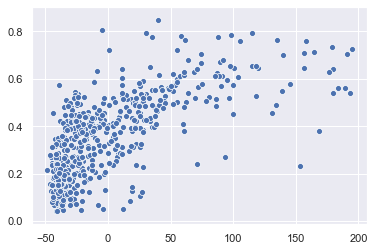

In [17]:
x = transform_1d(constits_id)
sns.scatterplot(x=x,y=scores['base'].values)

NameError: name 'X' is not defined

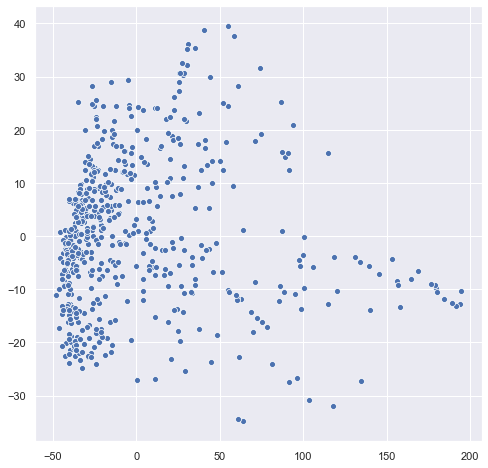

In [18]:
x,y = transform_2d(constits_id)
   
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x,y=y)
#values = preprocessing.scale(values)

val = pd.Series([name_from_onsid(i,election_results[year]) for i in X.index])
a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    
for c in constits_id:
    ax.text(x[constits_onsid_to_index[c]], y[constits_onsid_to_index[c]], name_from_onsid(c,election_results[year]))
    #ax.text(point['x']+.001, point['y'], str(point['val']))

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [20]:
kernel = 1.0 * RBF(length_scale=0.1, length_scale_bounds=(1e-4, 10)) \
    + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-10, 1e+1))

In [21]:
#kernel = 1.0 * RBF(length_scale=0.01)

In [22]:
from sklearn import preprocessing
X = preprocessing.scale(demographic_data)
y = scores['uns'].values
gp = GaussianProcessRegressor(kernel=kernel).fit(X, y, )

In [23]:
gp.predict(demographic_data.iloc[range(4)], return_std=True)
#gp.predict(np.arange(10).reshape(-1, 1), return_std=True)

(array([0., 0., 0., 0.]),
 array([0.04600662, 0.04600662, 0.04600662, 0.04600662]))

In [24]:
embedding = Isomap(n_components=1)
embedding.fit(X)
X_transformed = embedding.transform(X)
x = pd.Series(X_transformed[:,0])

<ErrorbarContainer object of 3 artists>

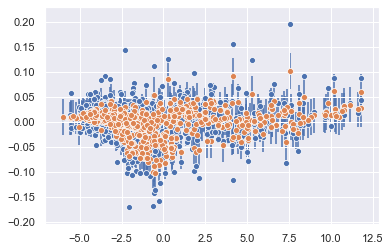

In [26]:
y_mean, y_std = gp.predict(X, return_std=True)
ax = sns.scatterplot(x=x,y=y)
ax = sns.scatterplot(x=x,y=y_mean)
ax.errorbar(x=x,y=y_mean,yerr=y_std,  fmt=' ', zorder=-1)

In [ ]:
#y_mean,y_std

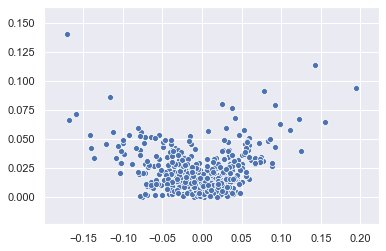

In [30]:
sns.scatterplot(x=y,y=abs(y-y_mean))

In [ ]:
sns.distplot()

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances

In [ ]:
X_scaled = preprocessing.scale(demographic_data)
dist_matrix = pairwise_distances(X_scaled)
sns.distplot(np.ndarray.flatten(dist_matrix))

In [ ]:
scores['Constituency'].iloc[np.where(dist_matrix == np.max(dist_matrix))[0]]

In [ ]:
def distance(X, cutoff=None):
    return pairwise_distances(X)

def distance_rescale_simple(X, cutoff):
    dist_matrix = distance(X)
    mask = dist_matrix > cutoff
    dist_matrix[mask] = 0
    return dist_matrix

def distance_rescale(X, cutoff):
    dist_matrix = distance(X)
    n = len(dist_matrix)
    for i in range(n):
        for j in range(n):
            if 0 < dist_matrix[i][j] < cutoff:
                dist_matrix[i][j] = 1 / (cutoff - dist_matrix[i][j])
            else: 
                dist_matrix[i][j] = 0
    return dist_matrix

def calc_significance_matrix(demographic_data, constit_score, 
                             dist_func=distance, cutoff=None):
    X_scaled      = preprocessing.scale(demographic_data)
    dist_matrix   = dist_func(X_scaled,cutoff)
    constit_score = preprocessing.scale(constit_score)
    score_matrix  = constit_score[:,np.newaxis] - constit_score
    significance  = np.zeros(score_matrix.shape) # need to initialise all to zero
    significance  = np.divide( score_matrix, dist_matrix, where=dist_matrix!=0)
    return significance
    
def calc_campaign_conf(demographic_data, constit_score, 
                             dist_func=distance, cutoff=None):
    assert np.all( demographic_data.index == constit_score.index )
    significance = calc_significance_matrix(demographic_data, constit_score, dist_func, cutoff)
    return pd.Series(np.sum(significance,1),index=constits_id)

In [ ]:
base = calc_campaign_conf(demographic_data, scores['base'])
diff = calc_campaign_conf(demographic_data, scores['diff'])
uns = calc_campaign_conf(demographic_data, scores['uns'])
mrp = calc_campaign_conf(demographic_data, scores['mrp'])

In [ ]:
cutoff = 2
base_cut = calc_campaign_conf(demographic_data, scores['base'],distance_rescale_simple, cutoff)
diff_cut = calc_campaign_conf(demographic_data, scores['diff'],distance_rescale_simple, cutoff)
uns_cut  = calc_campaign_conf(demographic_data, scores['uns'],distance_rescale_simple, cutoff)
mrp_cut  = calc_campaign_conf(demographic_data, scores['mrp'],distance_rescale_simple, cutoff)

In [ ]:
cutoff = 2
base_rescale = calc_campaign_conf(demographic_data, scores['base'],distance_rescale, cutoff)
diff_rescale = calc_campaign_conf(demographic_data, scores['diff'],distance_rescale, cutoff)
uns_rescale  = calc_campaign_conf(demographic_data, scores['uns'],distance_rescale, cutoff)
mrp_rescale  = calc_campaign_conf(demographic_data, scores['mrp'],distance_rescale, cutoff)

In [ ]:
results = pd.DataFrame({'constituency': constits_name,
                        'base':base, 'diff': diff, 'uns': uns, 'mrp': mrp,
                        'base_cut':base_cut,'diff_cut': diff_cut, 'uns_cut': uns_cut, 'mrp_cut': mrp_cut,
                        'base_rescale':base_rescale,'diff_rescale': diff_rescale, 'uns_rescale': uns_rescale, 'mrp_rescale': mrp_rescale},
                       index = constits_id)
results.head(10)

In [ ]:
from sklearn.metrics import r2_score


use MRP score as reference

In [ ]:
r2_score(
    preprocessing.scale(scores['mrp']),
    preprocessing.scale(results['uns_rescale'])
)

In [ ]:
sns.scatterplot(x=scores['mrp'],
                y=results['uns'])

In [ ]:
sns.scatterplot(x=scores['mrp'], y=results['uns_cut'])

In [ ]:
sns.scatterplot(x=scores['diff'], y=results['diff'])

In [ ]:
results.sort_values('diff_rescale',ascending=False).head(20)

In [ ]:
sns.scatterplot(scores['mrp'],results['mrp'])

In [ ]:
sns.scatterplot(results['diff_rescale'],results['uns_rescale'])

This cell is ment to plot constituencies by demographics, then draw lines between constits that contribute to its result.

In [ ]:
#centre = 'Ellesmere Port & Neston'
centre = 'Lancaster & Fleetwood'

significance_matrix = calc_significance_matrix(demographic_data, scores['uns'])
centre_i = constits_name_to_index[centre]
contributions = significance_matrix[centre_i]

# coi = constits of interest
coi   = [onsid_from_name(centre,election_results[year])]
linexs = []
lineys = []
values = []

N = 5
for i in np.flip(np.argsort(np.abs(contributions))[-N:]):
    onsid = demographic_data.index[i]
    coi += [onsid]
    values += [contributions[i]]
    print(contributions[i],name_from_onsid(onsid,election_results[year]))

from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, MDS, TSNE
embedding = Isomap(n_components=2)

X = demographic_data#[mask]
X_transformed = embedding.fit_transform(X)
x = pd.Series(X_transformed[:,0])
y = pd.Series(X_transformed[:,1])

for c in coi:
    linexs += [ [x[centre_i],x[constits_onsid_to_index[c]] ] ]
    lineys += [ [y[centre_i],y[constits_onsid_to_index[c]] ] ]
    
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x,y=y)
#values = preprocessing.scale(values)
for linex,liney,value in zip(linexs,lineys,values):
    plt.plot(linex,liney,linewidth=value*2, color='blue')

val = pd.Series([name_from_onsid(i,election_results[year]) for i in X.index])
a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    
for c in coi:
    ax.text(x[constits_onsid_to_index[c]], y[constits_onsid_to_index[c]], name_from_onsid(c,election_results[year]))
    #ax.text(point['x']+.001, point['y'], str(point['val']))

In [ ]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)

## Cluster

In [ ]:
from sklearn import cluster, covariance, manifold
from sklearn.cluster import AffinityPropagation

from sklearn import preprocessing
X = demographic_data
X_scaled = preprocessing.scale(X)

clustering = AffinityPropagation(verbose=True).fit(X)

In [ ]:
X = demographic_data.loc[marginals]
sizes = results['uns'].loc[marginals]
sizes = np.array(sizes) - min(sizes)
hues = list(pd.Series(clustering.labels_,index=results.index)[marginals])

from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, MDS, TSNE

embedding = Isomap(n_components=2)

X_transformed = embedding.fit_transform(X)
x = pd.Series(X_transformed[:,0])
y = pd.Series(X_transformed[:,1])
label = pd.Series([name_from_onsid(i,election_results[year]) for i in X.index])
label.index=range(len(X_transformed))

plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x,y=y,
                     size=sizes, sizes=(1, 1000),
                     hue=hues, palette='Set1')
a = pd.concat({'x': x, 'y': y, 'label': label}, axis=1)
for i, point in a.iterrows():
    ax.text(point['x']+.001, point['y'], str(point['label']))


In [ ]:
sns.distplot(sizes)